In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon

import utils
import utils.point_based


In /home/rohana/anaconda2/envs/geoGT/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rohana/anaconda2/envs/geoGT/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rohana/anaconda2/envs/geoGT/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/rohana/anaconda2/envs/geoGT/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rohana/

In [2]:
nyc_objs = pd.read_pickle('data/nyc/manhattan_parcels.pkl.zip')
houston_objs = pd.read_pickle('data/houston/inner_houston_parcels.pkl.zip')
sf_objs = pd.read_pickle('data/sf/sf_parcels.pkl.zip')

In [3]:
if not os.path.exists('data/nyc/manhattan_Z.npy'):
    nyc_polygons = [p.polygon for p in nyc_objs.parcels]
    nyc_Z = utils.polygon_based.cluster_finder(nyc_polygons)
else:
    nyc_Z = np.load('data/nyc/manhattan_Z.npy')

nyc_cluster = utils.polygon_based.cluster_wrapper(nyc_Z, nyc_objs.iloc[:, 0],
                                                  discretize=True, verbose=False)
    
if not os.path.exists('data/houston/inner_houston_Z.npy'):
    houston_polygons = [p.polygon for p in houston_objs.parcels]
    houston_Z = utils.polygon_based.cluster_finder(houston_polygons)
else:
    houston_Z = np.load('data/houston/inner_houston_Z.npy')
    
houston_cluster = utils.polygon_based.cluster_wrapper(houston_Z, houston_objs.iloc[:, 0],
                                                      discretize=True, verbose=False)
    
if not os.path.exists('data/sf/sf_cluster.pkl'):
    sf_cluster = utils.point_based.cluster_finder(sf_objs.parcels, 300, verbose=True)
    with open('data/sf/sf_cluster.pkl', 'wb') as handle:
        pickle.dump(sf_cluster, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('data/sf/sf_cluster.pkl', 'rb') as handle:
        sf_cluster = pickle.load(handle)
    sf_cluster.re_thresh(0)


## Example Merges

1000.0 m


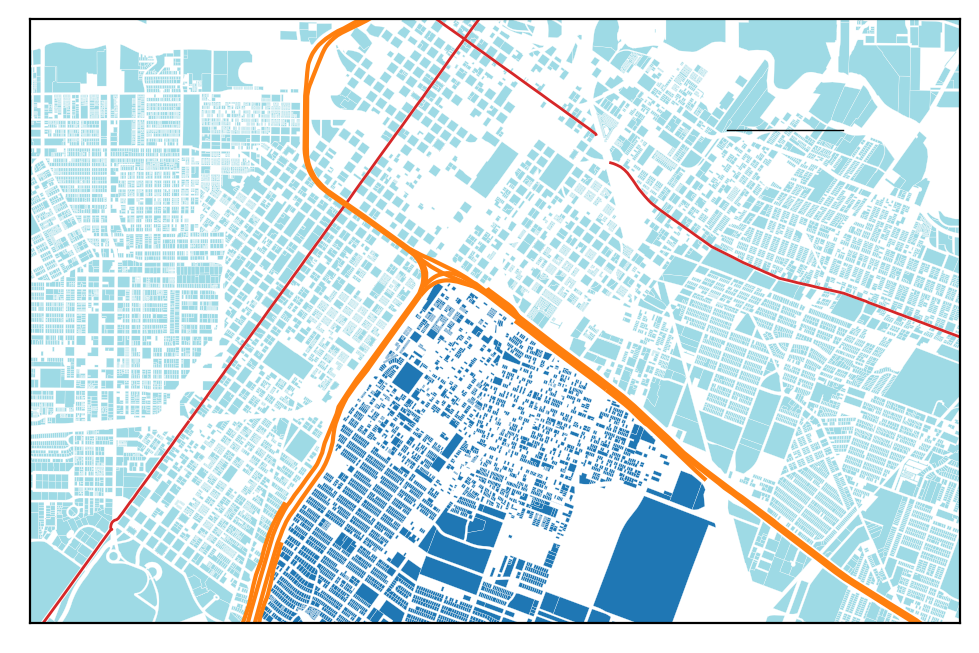

In [4]:
third_ward_boundarires = gpd.read_file('data/houston/third_ward_boundaries/')
old_boundaries = third_ward_boundarires[third_ward_boundarires.age=='old']
new_boundaries = third_ward_boundarires[third_ward_boundarires.age=='new']

def largest_at_level(cluster, levels):
    if levels <= 0:
        return cluster
    idx = np.argmax([len(sc.parcels) for sc in cluster.sub_clusters])
    return largest_at_level(cluster.sub_clusters[idx], levels-1)

houston_cluster_trimmed = largest_at_level(houston_cluster, 9)

x_bounds = (268000, 276000)
y_bounds = (3290000, 3294700)


f, ax = plt.subplots(dpi=200)
utils.plot_clusters(reversed(utils.get_exists_at(houston_cluster_trimmed, 89)), ax=ax)

old_boundaries.plot(ax=ax, color='tab:red', linewidth=1)
new_boundaries.plot(ax=ax, color='tab:orange')

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# f.tight_layout()

utils.utm_scale_bar_guide(ax, pos=(.75, .85), linewidth=.5)

plt.show()

1000.0 m


<AxesSubplot:>

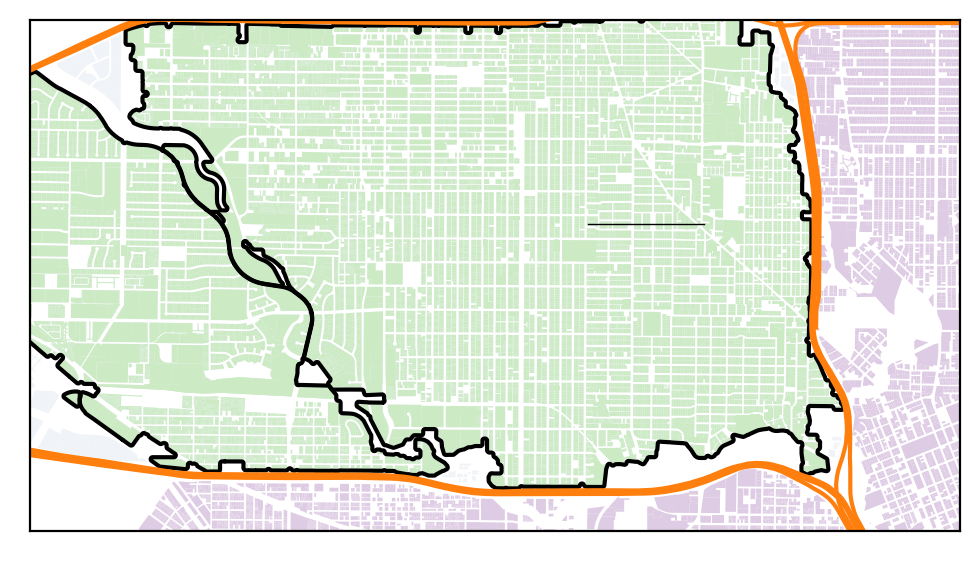

In [5]:
x_bounds = (264000, 272000)
y_bounds = (3296100, 3300500)

northwest = gpd.read_file('data/houston/northwest_loop_highways/')

katy_merge = largest_at_level(houston_cluster_trimmed, 4)

for sc in katy_merge.sub_clusters:
    if len(sc.parcels) == 110345:
        non_isolated = sc
    elif len(sc.parcels) == 24997:
        isolated = sc

f, ax = plt.subplots(dpi=200)

katy_b, katy_p, katy_o = utils.plot_with_interal_edge(isolated, 34, return_df=True)

katy_b.plot(ax=ax, color='#f0f3f7')
katy_p.plot(ax=ax, color='#ccebc5')
katy_o.plot(ax=ax, color='k')
gpd.GeoSeries([p.polygon for p in non_isolated.parcels]).plot(ax=ax, color='#decbe4')
northwest.plot(ax=ax, color='tab:orange')
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

utils.utm_scale_bar_guide(ax, pos=(.6, .6), linewidth=.5)

## Scales of Neighborhood Partition

In [6]:
houston_probs = utils.desc_probs(houston_cluster)
nyc_probs = utils.desc_probs(nyc_cluster)
sf_probs = utils.desc_probs(sf_cluster)

/mnt/miscdata/repos/auto-urban-substructure-ident/utils/transitions.py:31: RuntimeWarning: divide by zero encountered in true_divide
  transition_mat = transition_mat / transition_mat.sum(axis=1)[:, np.newaxis]
/mnt/miscdata/repos/auto-urban-substructure-ident/utils/transitions.py:31: RuntimeWarning: invalid value encountered in true_divide
  transition_mat = transition_mat / transition_mat.sum(axis=1)[:, np.newaxis]


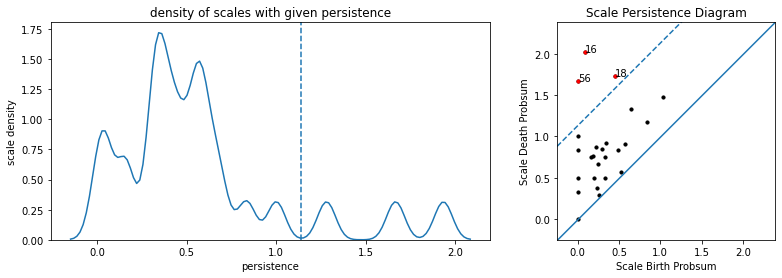

houston [16, 18, 56]


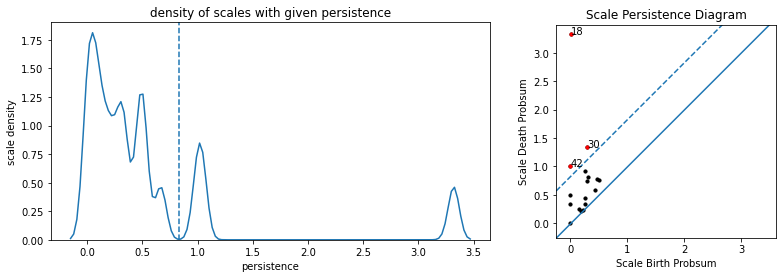

nyc [18, 30, 42]


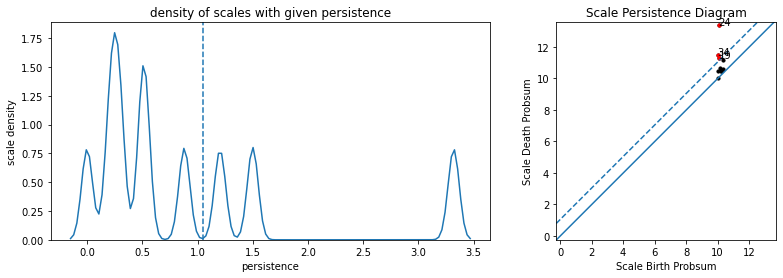

sf [19, 24, 34]


In [7]:
houston_persistent_global = sorted(utils.composite_persistence_plot(houston_probs, tau=1.14).values())
print('houston', houston_persistent_global)
nyc_persistent_global = sorted(utils.composite_persistence_plot(nyc_probs, tau=.83).values())
print('nyc', nyc_persistent_global)
sf_persistent_global = sorted(utils.composite_persistence_plot(sf_probs, tau=1.05, firstok=11).values())
print('sf', sf_persistent_global)

(1, 50)


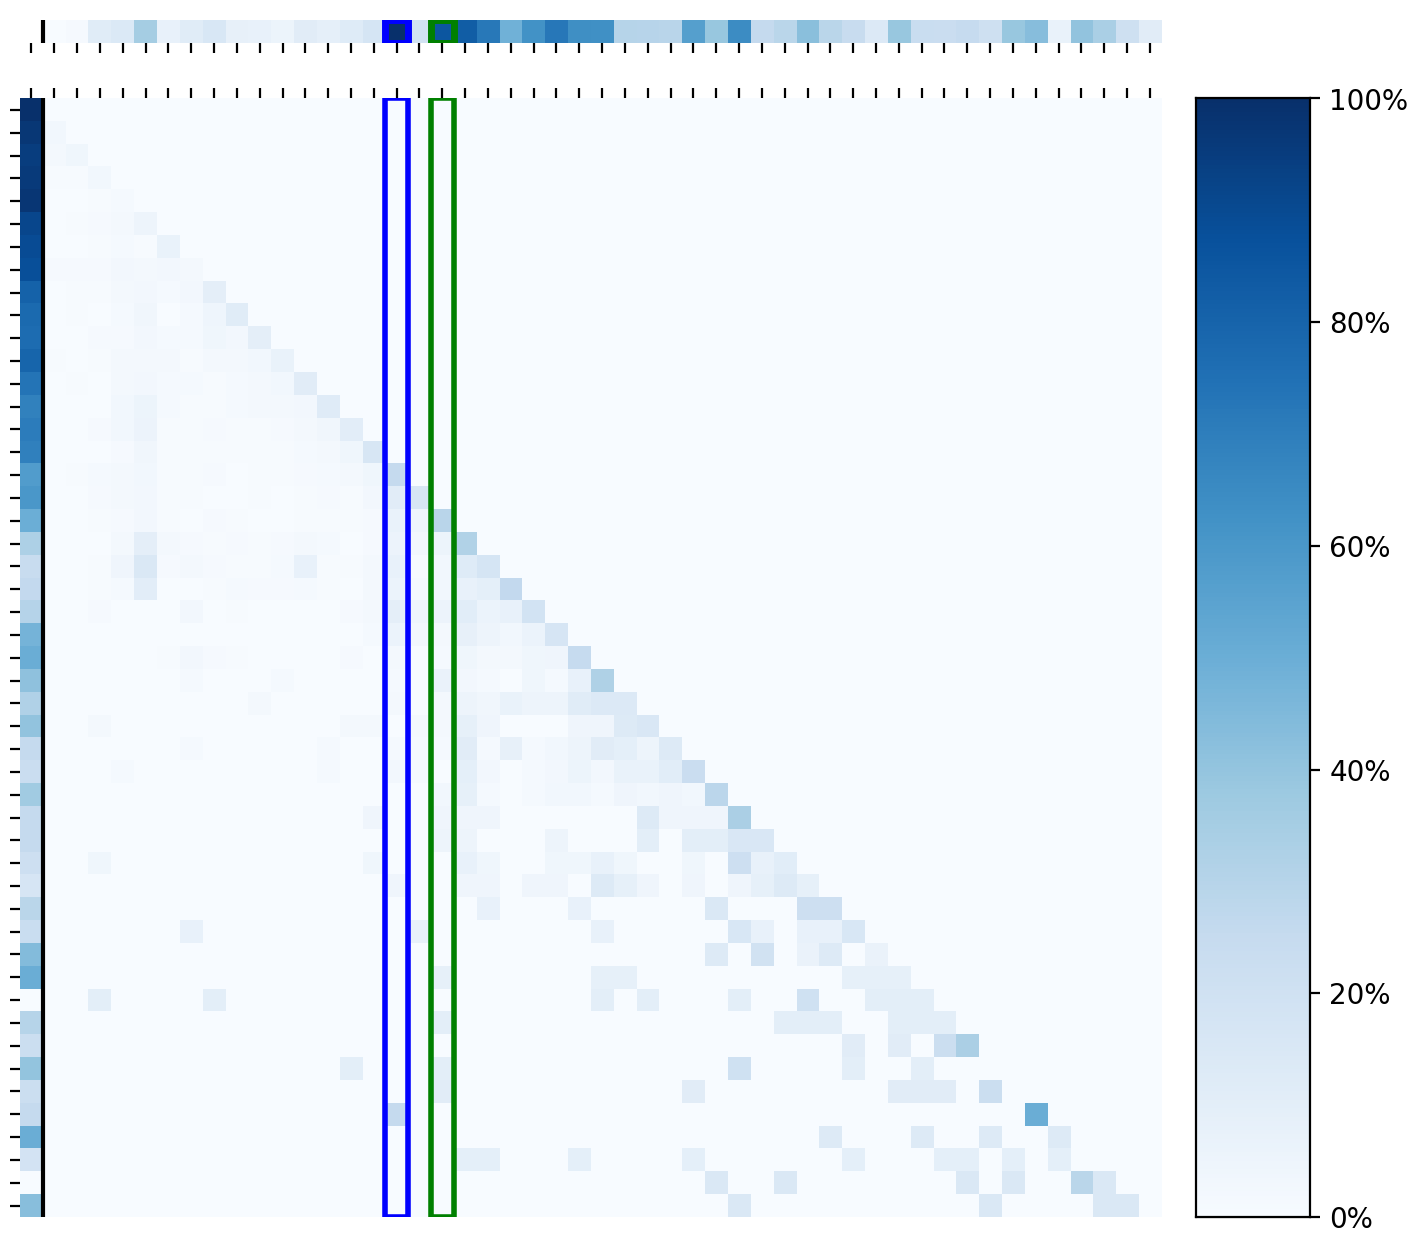

In [8]:
f, ax = plt.subplots(figsize=(10, 8), dpi=200)
utils.plot_transitions(houston_probs, ax=ax, firstok=1, maxdim=50, labels=False,
                       highlights=[s for s in houston_persistent_global if s < 50])

debug 2


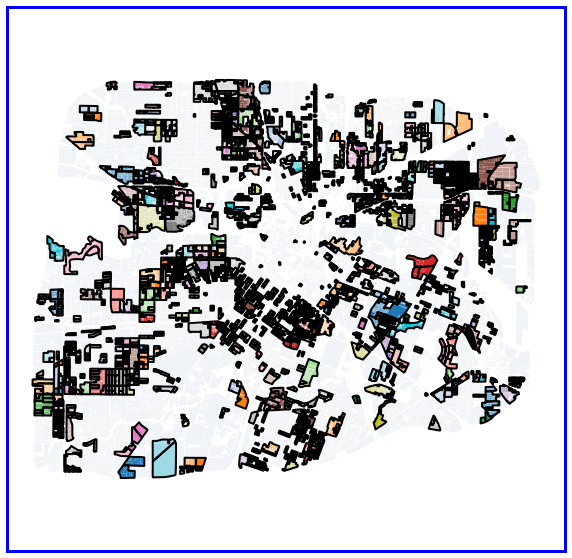

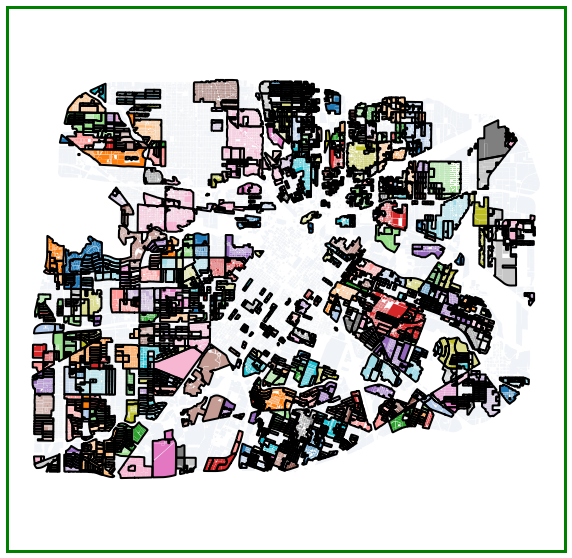

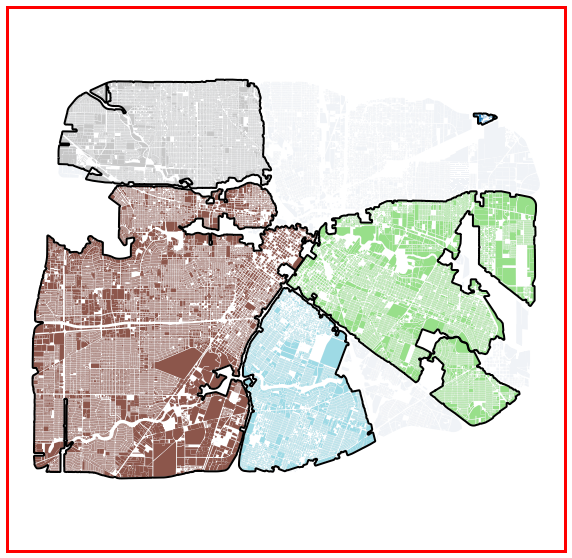

In [9]:
for eps, color in zip(houston_persistent_global[:3], ['b', 'g', 'r']):
    ax = utils.plot_with_interal_edge(houston_cluster, eps, border_color=color, border_width=3, debug=True)
#     utils.utm_scale_bar_guide(ax, pos=(.1, .9), size=.2, linewidth=.5)
    plt.show()


(1, 50)


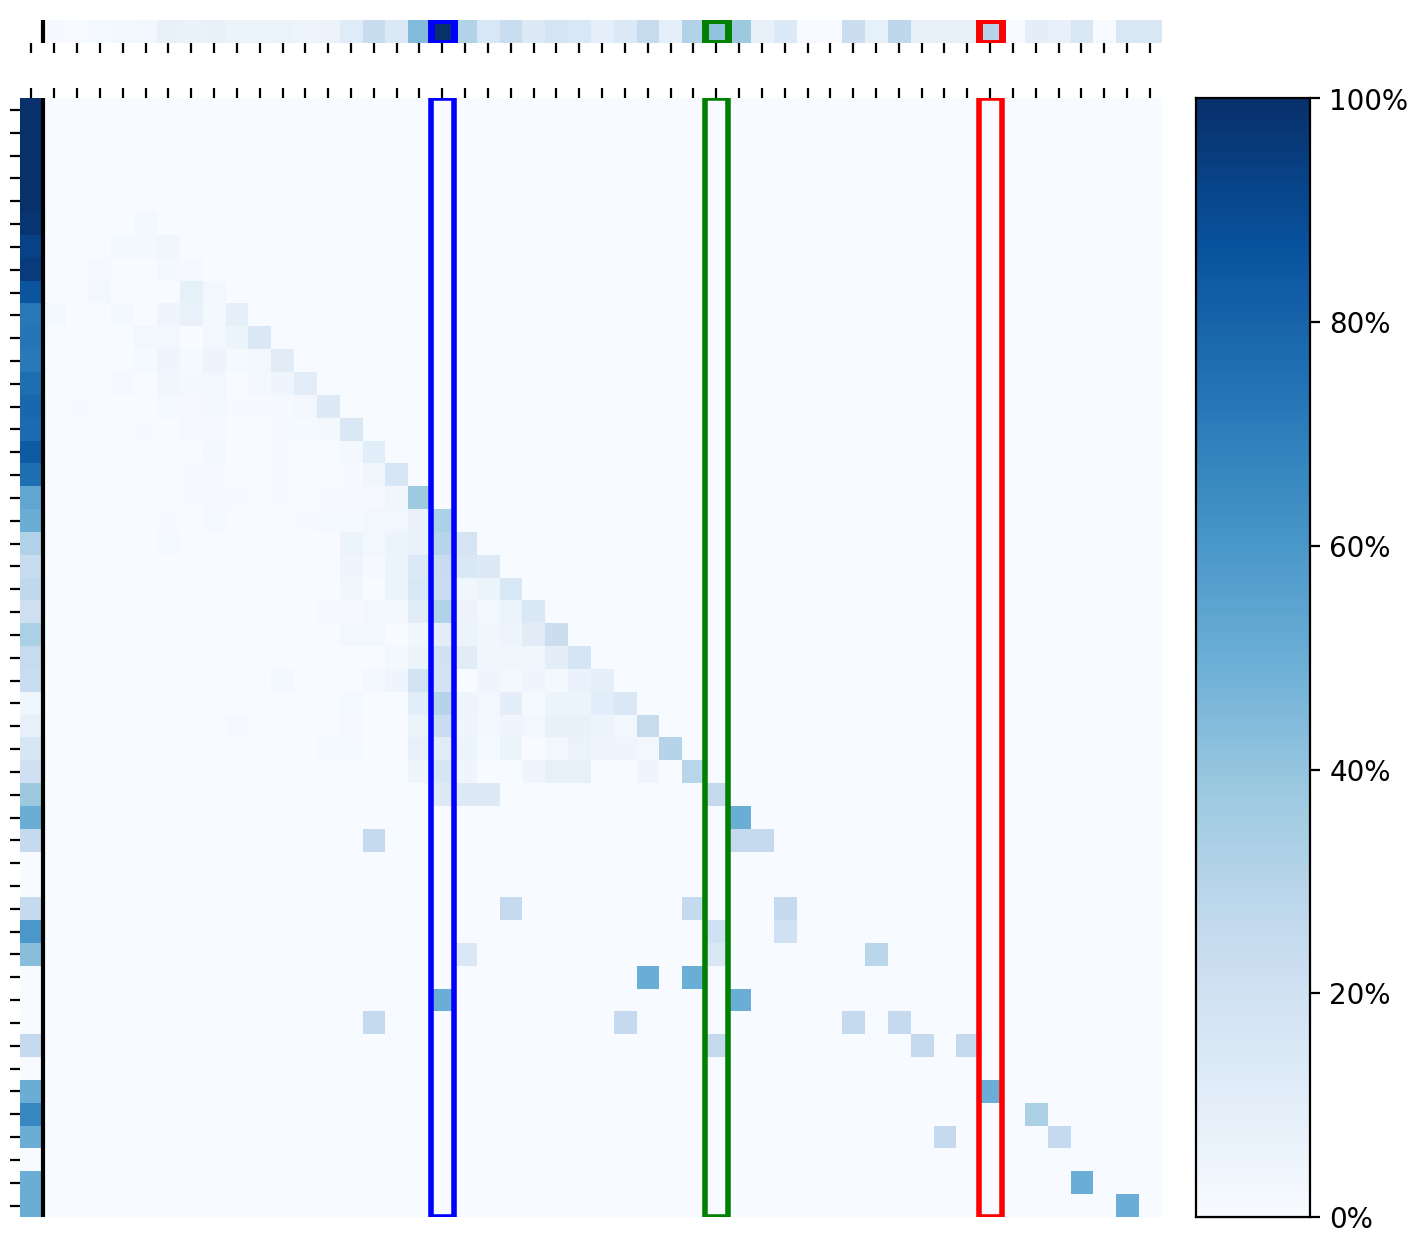

In [10]:
f, ax = plt.subplots(figsize=(10, 8), dpi=200)
utils.plot_transitions(nyc_probs, firstok=1, ax=ax, maxdim=50, labels=False,
                       highlights=[s for s in nyc_persistent_global if s < 50])

1000.0 m


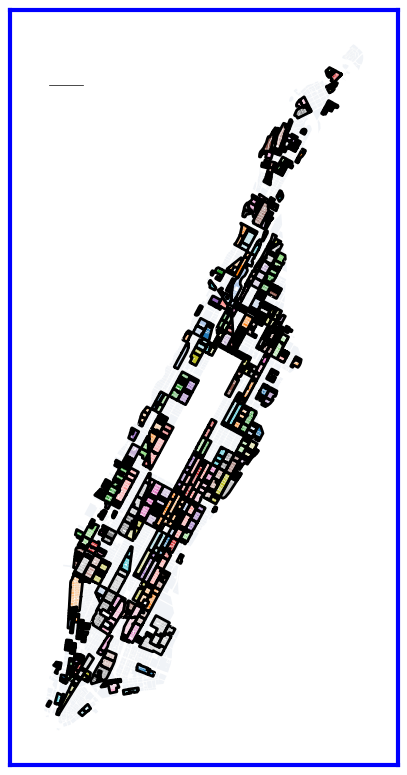

1000.0 m


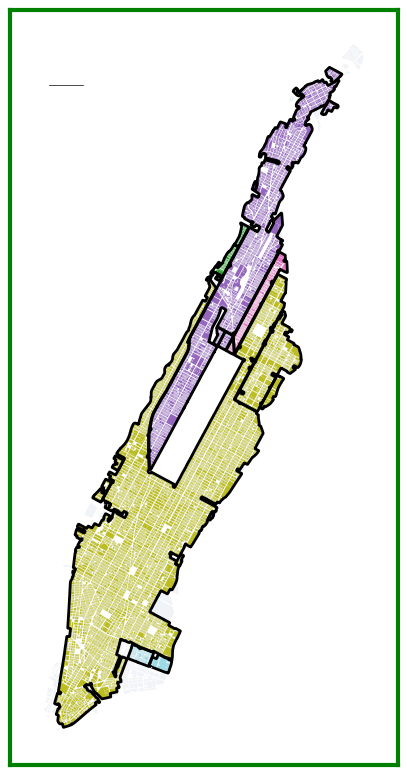

1000.0 m


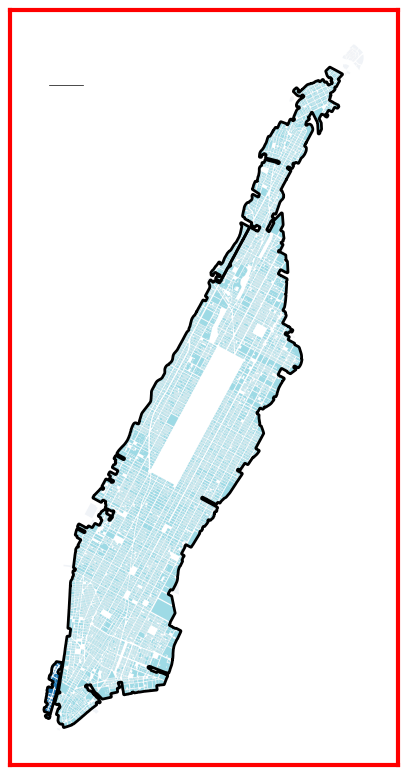

In [11]:
for eps, color in zip(nyc_persistent_global[:3], ['b', 'g', 'r']):
    f, ax = plt.subplots(figsize=(5,10), dpi=100)
    ax = utils.plot_with_interal_edge(nyc_cluster, eps, border_color=color, border_width=3, debug=True, ax=ax)
    utils.utm_scale_bar_guide(ax, pos=(.1, .9), size=.2, linewidth=.5)
    plt.show()


(1, 40)


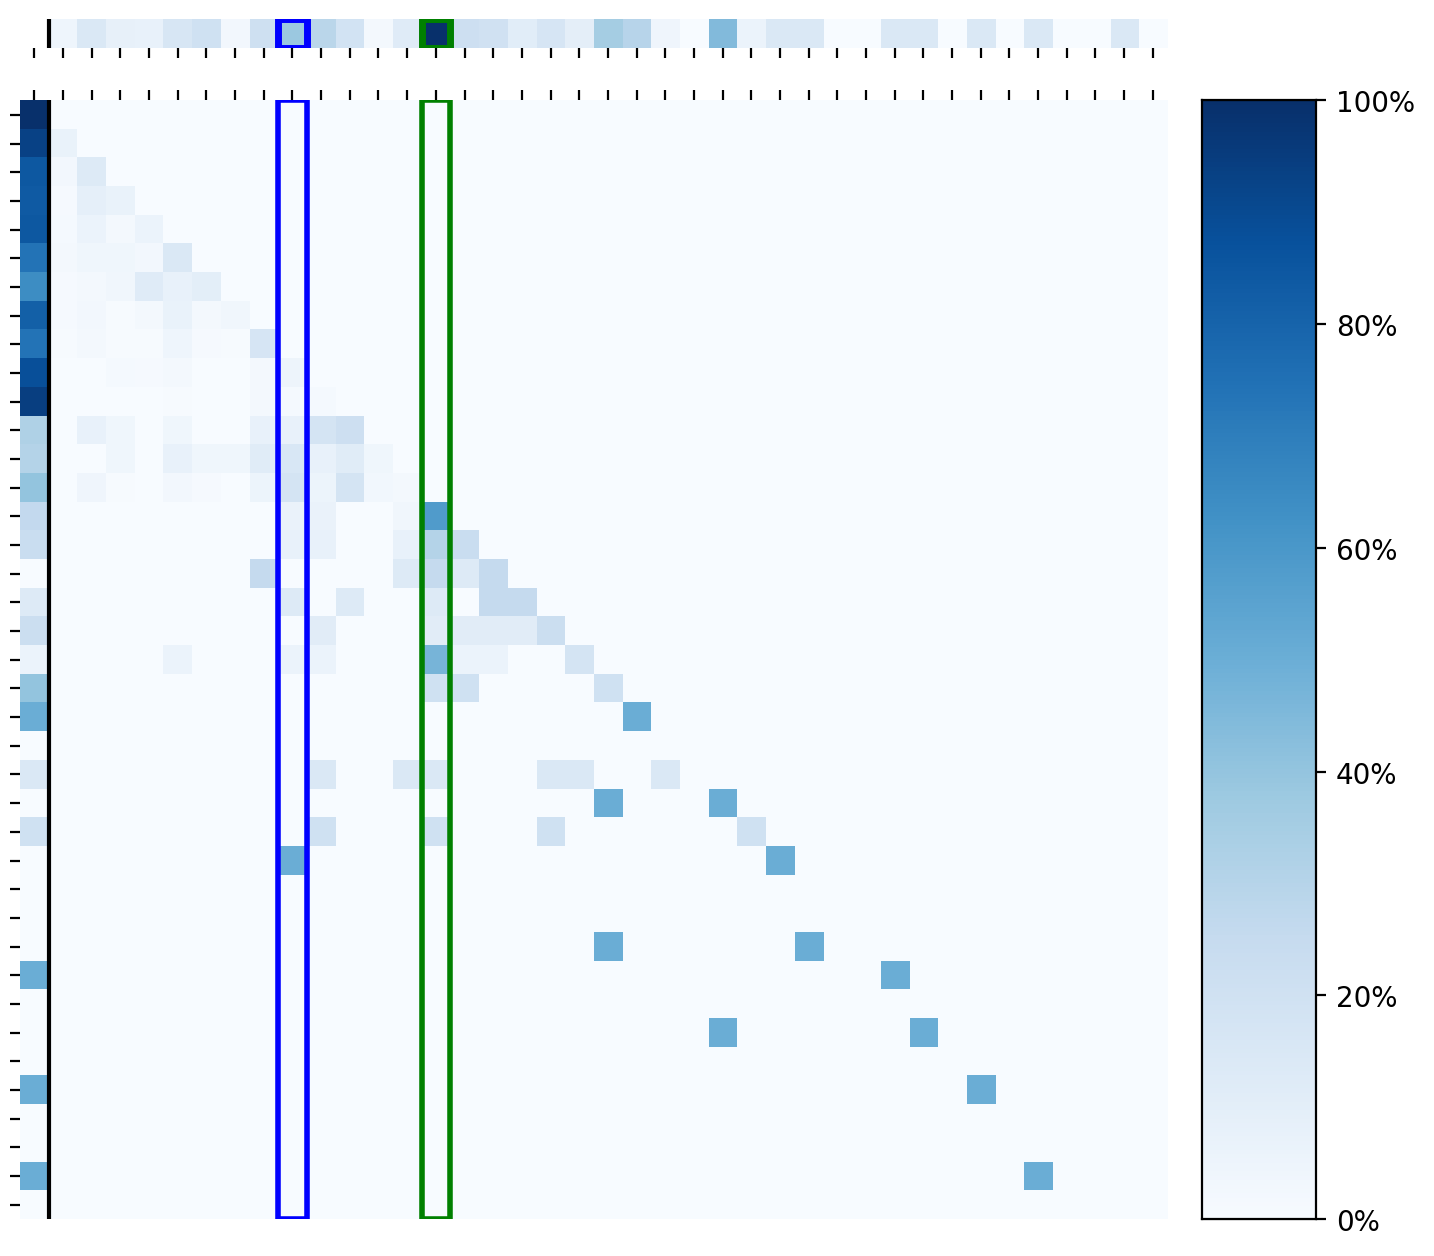

In [12]:
f, ax = plt.subplots(figsize=(10, 8), dpi=200)
utils.plot_transitions(sf_probs, firstok=11, ax=ax, maxdim=50, labels=False,
                       highlights=sf_persistent_global[:2])

1000.0 m


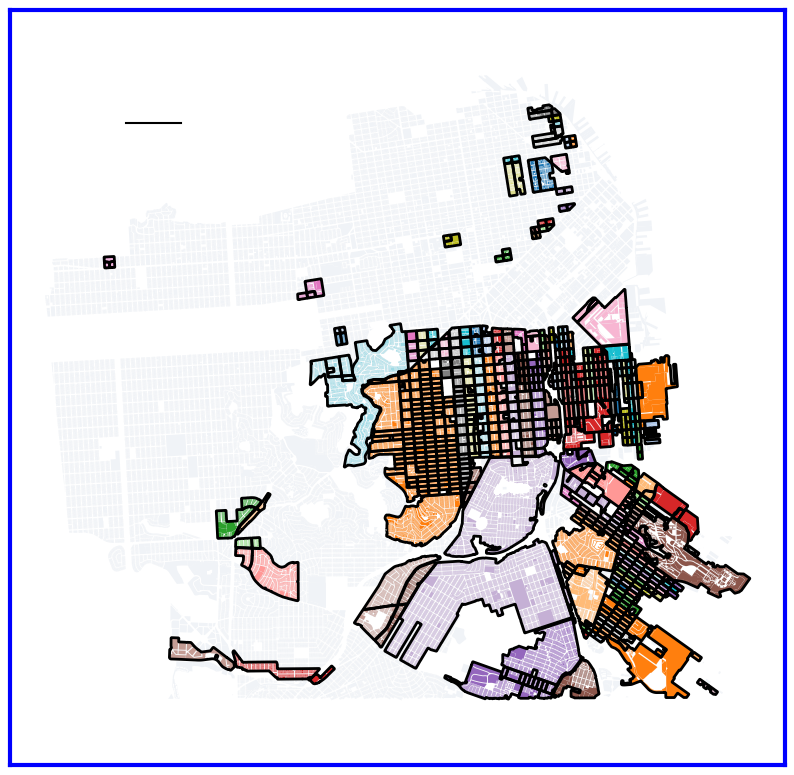

1000.0 m


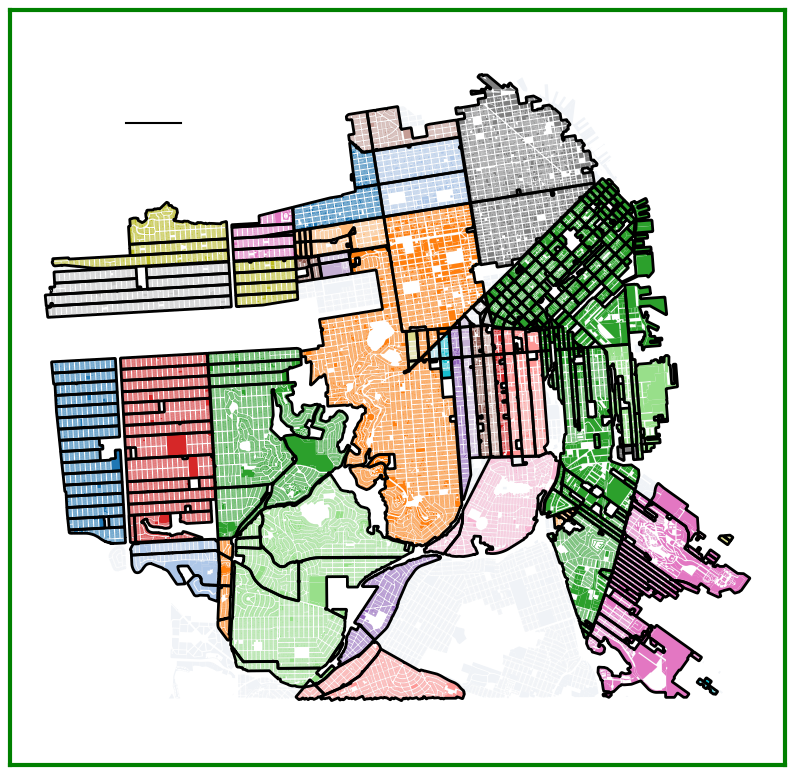

In [13]:
for eps, color in zip(sf_persistent_global[:3], ['b', 'g']):
    f, ax = plt.subplots(figsize=(10,10), dpi=100)
    ax = utils.plot_with_interal_edge(sf_cluster, eps, border_color=color, border_width=3, debug=True, ax=ax)
    utils.utm_scale_bar_guide(ax, pos=[.15, .85])
    plt.show()
